### Necessary Imports

In [30]:
import numpy as np
import cv2 
import matplotlib.pyplot as plt
from numpy.fft import fft2, ifft2, fftshift, ifftshift
import os
from io import BytesIO

In [31]:
OUTDIR='./outputs'

### Question 1. Directional Filtering

In [32]:
class A3_Q1:
    def __init__(self, M=256):
        self.M = M
        self.m = np.arange(M)
        self.n = np.arange(M)
        self.Mgrid, self.Ngrid = np.meshgrid(self.m, self.n, indexing='ij')
        self._prepare_images()
        self._prepare_spectrum()
        self.outdir = "./outputs/q1"
        os.makedirs(self.outdir, exist_ok=True)

    def _prepare_images(self):
        M, mg, ng = self.M, self.Mgrid, self.Ngrid
        self.x1 = np.sin(2 * np.pi * 12 * mg / M)
        self.x2 = np.sin(2 * np.pi * 8 * ng / M)
        self.x3 = np.sin(2 * np.pi * (6 * mg + 10 * ng) / M)
        self.x = (self.x1 + self.x2 + self.x3) / 3.0

    def _prepare_spectrum(self):
        self.X = fftshift(fft2(self.x))
        self.X_mag = np.abs(self.X)
        self.X_logmag = np.log1p(self.X_mag)

    def part_a_plot(self, save=True):
        titles = [
            'x1: sin(2π·12·m/M)', 'x2: sin(2π·8·n/M)', 'x3: sin(2π(6m+10n)/M)',
            'Combined x (average)', 'Centered 2D DFT magnitude (log)'
        ]
        imgs = [self.x1, self.x2, self.x3, self.x, self.X_logmag]
        fig, axes = plt.subplots(1, 5, figsize=(20, 4))
        for ax, img, title in zip(axes, imgs, titles):
            ax.imshow(img, origin='lower', cmap='gray')
            ax.set_title(title)
            ax.set_xticks([]); ax.set_yticks([])
        plt.tight_layout()
        if save:
            path = os.path.join(self.outdir, "part_a_combined.png")
            plt.savefig(path, dpi=150)
            return path
        plt.show()

        

    def directional_filter(self, theta_min_deg, theta_max_deg):
        M = self.M
        u = np.arange(-M//2, M//2)
        v = np.arange(-M//2, M//2)
        U, V = np.meshgrid(u, v, indexing='ij')

        theta = np.arctan2(V, U) 

        tmin = np.deg2rad(theta_min_deg)
        tmax = np.deg2rad(theta_max_deg)

        if tmin <= tmax:
            mask = (theta >= tmin) & (theta <= tmax)
        else:
            mask = (theta >= tmin) | (theta <= tmax)

        return mask.astype(np.uint8)


    def magnitude_spectrum(self, H):
        H_dft = np.abs(fft2(H))
        return np.log1p(fftshift(H_dft)**0.1)

    def _visualize_filter_and_recon(self, H, name, save=True):
        Xf = H * self.X
        recon = np.real(ifft2(ifftshift(Xf)))

        fig, axes = plt.subplots(1, 5, figsize=(20, 4))
        titles = [
            'Original image', 'Original spectrum (log)',
            f'Directional Filter {name}', 'Filtered spectrum (log)',
            f'Reconstructed {name}'
        ]
        images = [
            self.x, self.X_logmag, H,
            np.log1p(np.abs(Xf)), recon
        ]

        for ax, img, title in zip(axes, images, titles):
            ax.imshow(img,origin='lower', cmap='gray')
            ax.set_title(title)
            ax.set_xticks([]); ax.set_yticks([])

        plt.tight_layout()
        if save:
            path = os.path.join(self.outdir, f"{name}_filtered.png")
            plt.savefig(path, dpi=150)
            return path, recon
        plt.show()

    def part_b_apply_filters(self, save=True):
        filters = {
            "H1": self.directional_filter(-20, 20),
            "H2": self.directional_filter(70, 110),
            "H3": self.directional_filter(25, 65)
        }
        filters["H4"] = np.maximum(np.maximum(filters["H1"], filters["H2"]), filters["H3"])

        self.filter_results = {}
        for name, H in filters.items():
            path, recon = self._visualize_filter_and_recon(H, name, save)
            self.filter_results[name] = {"H": H, "recon": recon, "fig_path": path}
        return self.filter_results

    def part_c_mse(self):
        if not hasattr(self, 'filter_results'):
            raise RuntimeError("Run part_b_apply_filters() first.")
        orig = self.x
        return {
            name: np.mean((orig - info["recon"]) ** 2)
            for name, info in self.filter_results.items()
        }

    def run_all(self):
        self.part_a_plot(save=True)
        self.part_b_apply_filters(save=True)
        return self.part_c_mse()


{'H1': 0.125, 'H2': 0.125, 'H3': 0.125, 'H4': 0.04166666666666666}


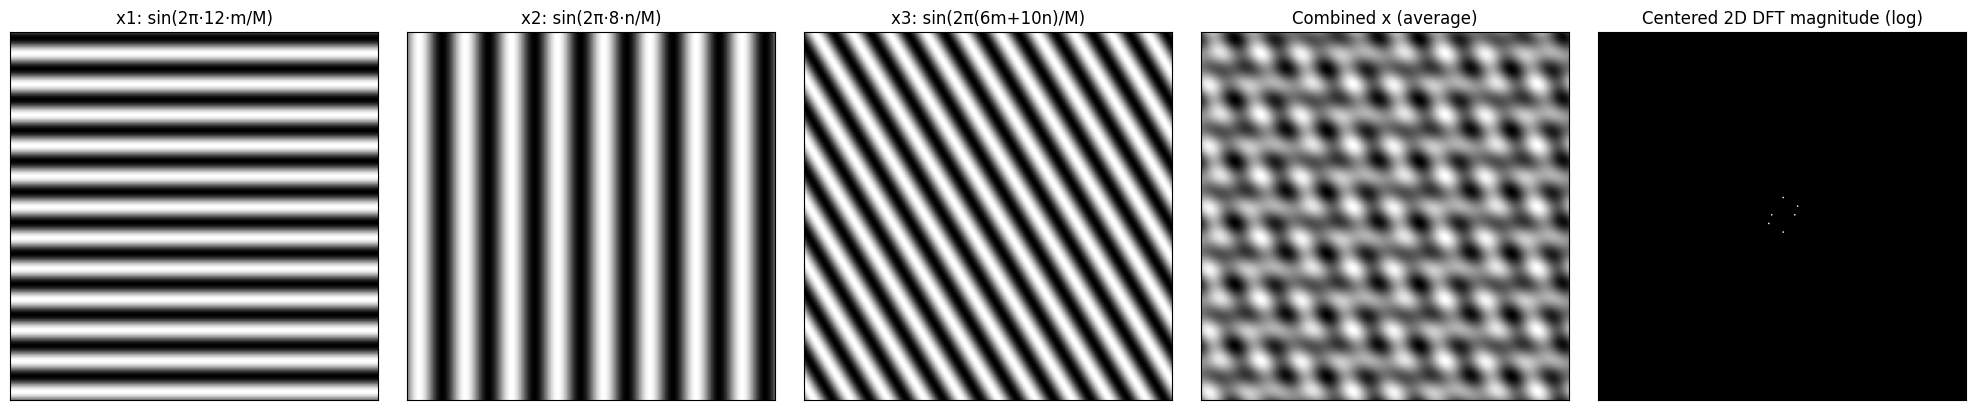

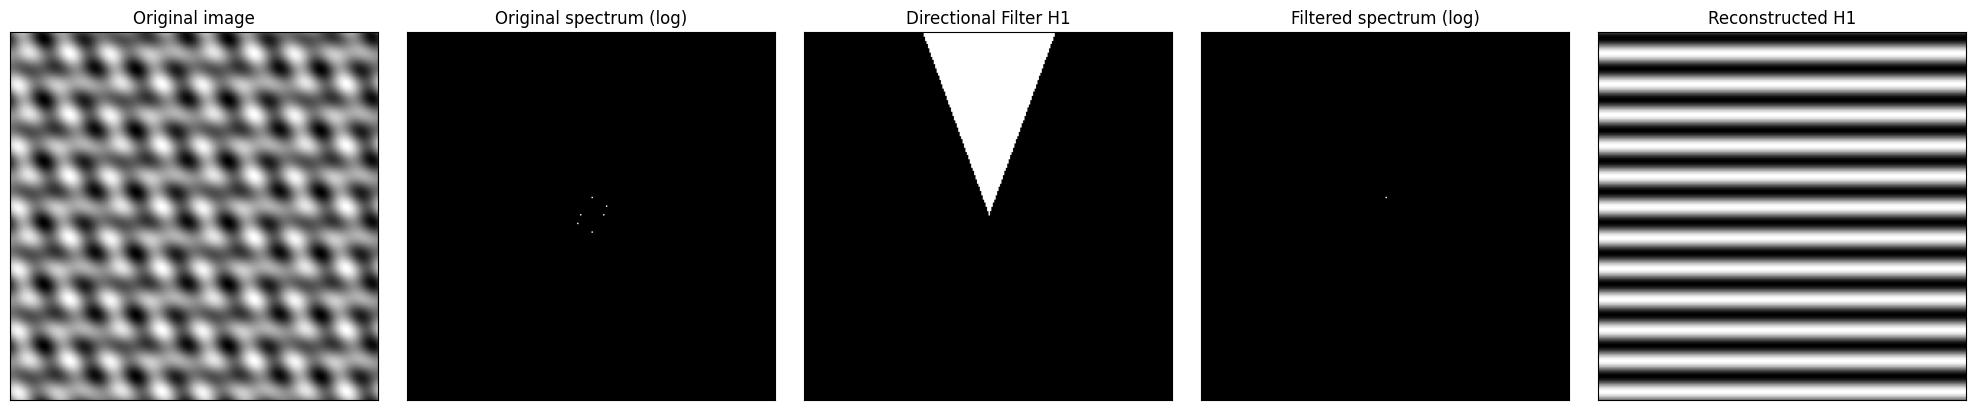

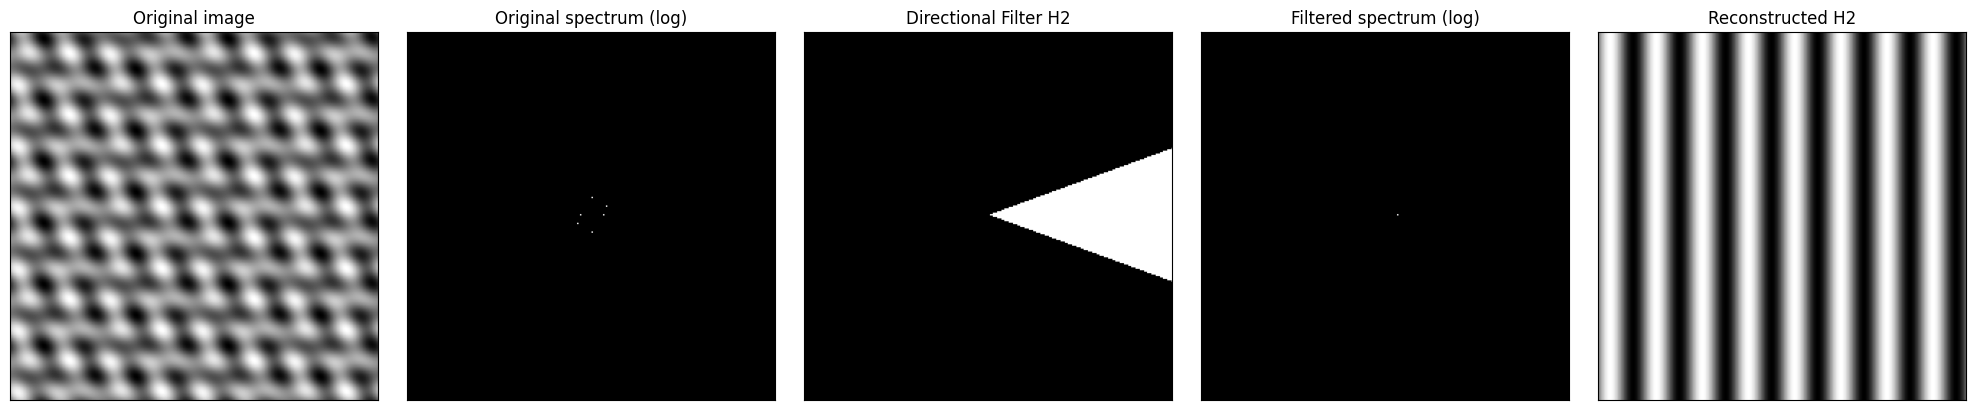

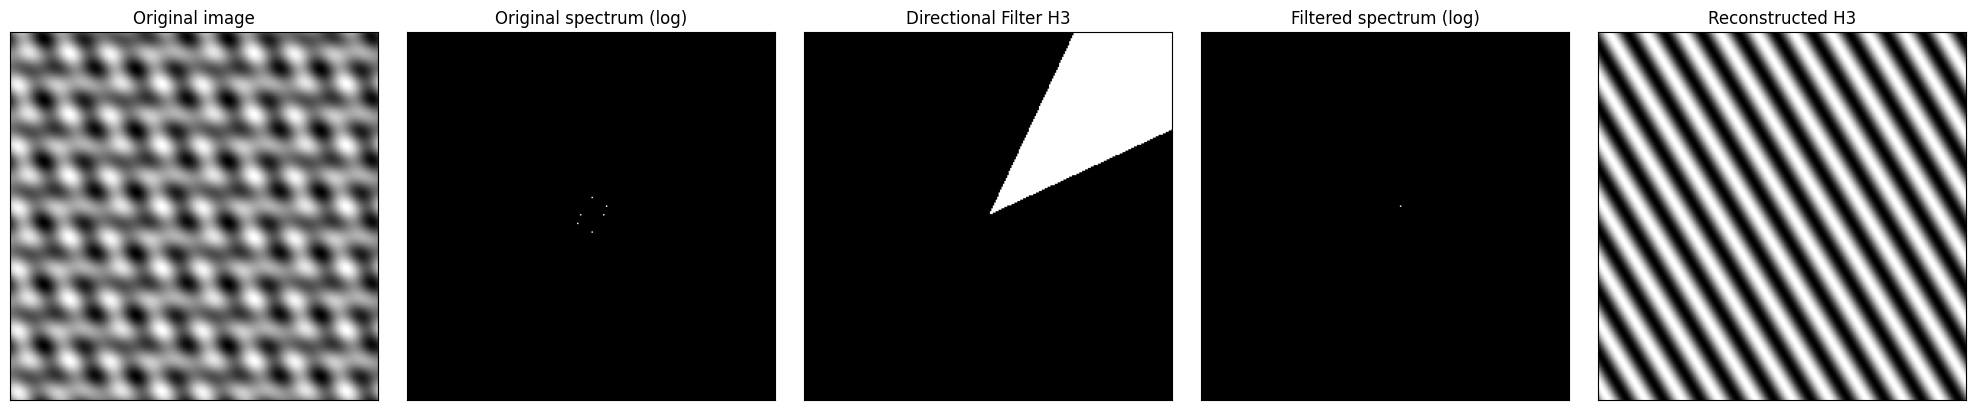

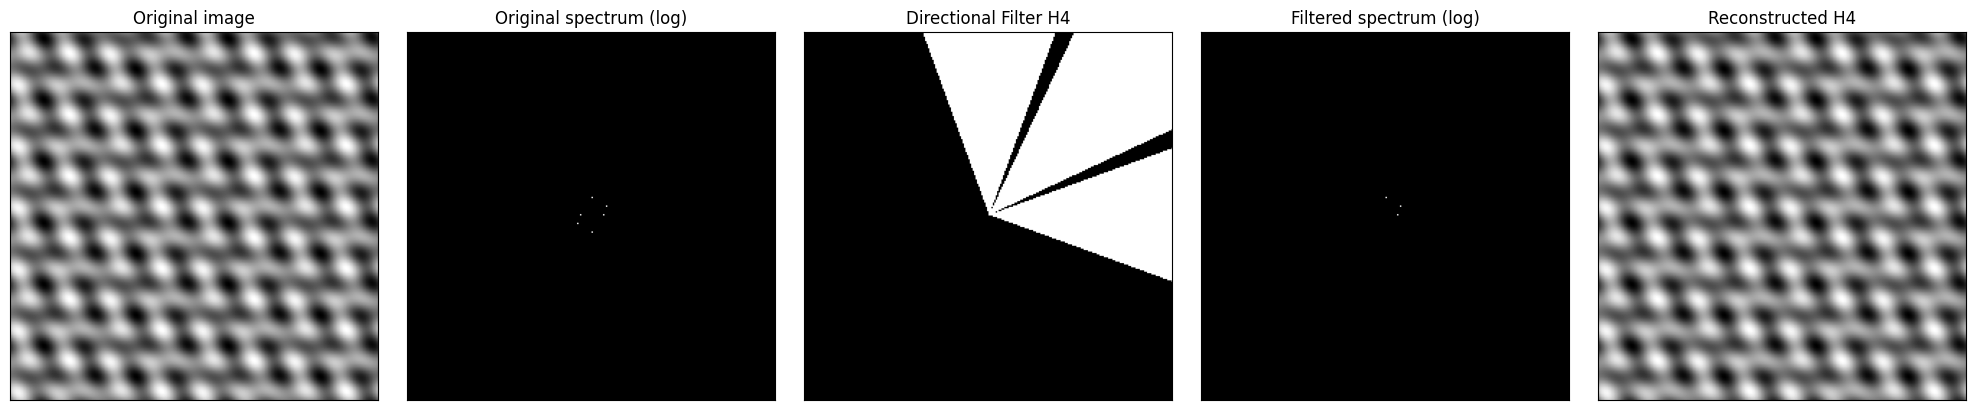

In [33]:
a3q1 = A3_Q1(M=256)
summary = a3q1.run_all()
print(summary)


### Q2. Gaussian Blurring and Inverse Filtering

In [34]:
def load_image(image_path='./inputs/buildings.jpg'):
    # Load RGB image
    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError(f"Image not found: {image_path}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def gaussian_kernel(size, sigma):
    ax = np.arange(-size // 2 + 1., size // 2 + 1.)
    xx, yy = np.meshgrid(ax, ax)
    kernel = np.exp(-(xx**2 + yy**2) / (2 * sigma**2))
    kernel = kernel / np.sum(kernel)
    return kernel

def magnitude_spectrum(kernel, dft_size):    
    padded = np.zeros((dft_size, dft_size))
    k_size = kernel.shape[0]
    k_half = k_size // 2
    center = dft_size // 2
    padded[center-k_half:center-k_half+k_size, center-k_half:center-k_half+k_size] = kernel
    H_dft = np.abs(fft2(padded))
    return fftshift(H_dft)

def inverse_magnitude_spectrum(H):
    return 1/(H + 1e-3)

def compute_mse(image1, image2):
    return np.mean((image1 - image2) ** 2)

Part 2.a


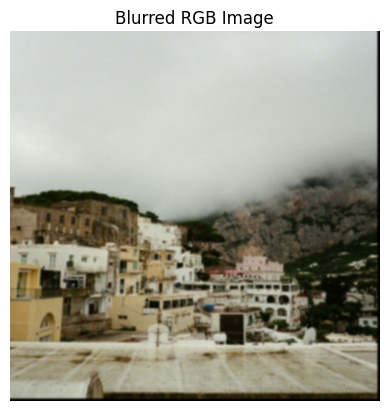

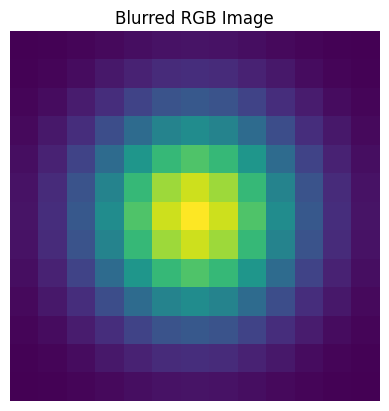

In [35]:
# def blur_image_in_freq_domain():
kernel_size = 13
sigma = 2.5
image_path='./inputs/buildings.jpg'
kernel = gaussian_kernel(kernel_size, sigma)
img = load_image(image_path)
img = img.astype(np.float64) / 255.0  # Normalize to [0,1]
outdir = os.path.join(OUTDIR, 'q2')
os.makedirs(outdir, exist_ok=True)

H_img, W_img, _ = img.shape
kh, kw = kernel.shape
Hpad = H_img + kh - 1
Wpad = W_img + kw - 1

# Pad and center kernel (shift to origin)
pad_kernel = np.zeros((Hpad, Wpad), dtype=np.float64)
pad_kernel[:kh, :kw] = kernel
pad_kernel = np.roll(pad_kernel, -kh//2, axis=0)
pad_kernel = np.roll(pad_kernel, -kw//2, axis=1)
H = fft2(pad_kernel)  

# Apply blur channel-wise
blurred_rgb = np.zeros_like(img)
for c in range(3):
    pad_img = np.zeros((Hpad, Wpad))
    pad_img[:H_img, :W_img] = img[:, :, c]
    IMG = fft2(pad_img)
    BLUR = IMG * H
    pad_blur = np.real(ifft2(BLUR))
    start_h, start_w = kh // 2, kw // 2
    blurred_rgb[:, :, c] = pad_blur[start_h:start_h + H_img, start_w:start_w + W_img]

blurred = np.clip(blurred_rgb, 0, 1)
print("Part 2.a")

plt.imsave(os.path.join(outdir, "part_a.png"), blurred)
plt.imshow(blurred)
plt.axis('off')
plt.title("Blurred RGB Image")
plt.show()
plt.imsave(os.path.join(outdir, "kernel.png"), kernel)
plt.imshow(kernel)
plt.axis('off')
plt.title("Blurred RGB Image")
plt.show()


Part 2.b


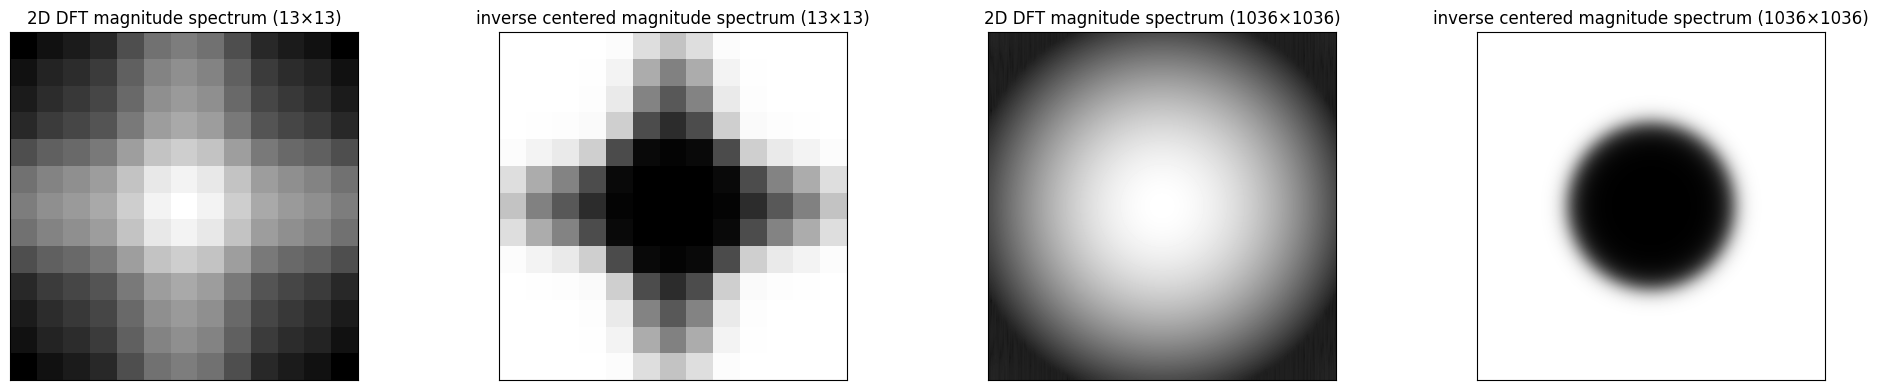

In [36]:
outdir = os.path.join(OUTDIR, 'q2')
os.makedirs(outdir, exist_ok=True)
H13 = gaussian_kernel(13, sigma)
H1036 = gaussian_kernel(1036, sigma)
magnitude_spectrum_13 = magnitude_spectrum(H13, 13)
magnitude_spectrum_13_view = np.log1p(magnitude_spectrum_13**0.01)
inverse_magnitude_spectrum_13 = inverse_magnitude_spectrum(magnitude_spectrum_13)
log_inverse_magnitude_spectrum_13 = np.log10(inverse_magnitude_spectrum_13)
magnitude_spectrum_1036 = magnitude_spectrum(H1036, 1036)
magnitude_spectrum_1036_view = np.log1p(magnitude_spectrum_1036**0.01)
inverse_magnitude_spectrum_1036 = inverse_magnitude_spectrum(magnitude_spectrum_1036)
log_inverse_magnitude_spectrum_1036 = np.log10(inverse_magnitude_spectrum_1036)

titles = ['2D DFT magnitude spectrum (13×13)', 'inverse centered magnitude spectrum (13×13)', '2D DFT magnitude spectrum (1036×1036)',
            'inverse centered magnitude spectrum (1036×1036)']
fig, axes = plt.subplots(1, 4, figsize=(20, 4))
for ax, img, title in zip(axes, [magnitude_spectrum_13_view, inverse_magnitude_spectrum_13, magnitude_spectrum_1036_view, inverse_magnitude_spectrum_1036], titles):
    ax.imshow(img, origin='lower', cmap='gray')
    ax.set_title(title)
    ax.set_xticks([]); ax.set_yticks([])

print("Part 2.b")
plt.tight_layout()
path = os.path.join(outdir, "part_b.png")
plt.savefig(path, dpi=150, bbox_inches='tight')
plt.show()


Part 2.c.ii
Optimal k = 0.0014369560853693662
Minimum Error = 7.318154466490909e-07


Part 2.c.iii


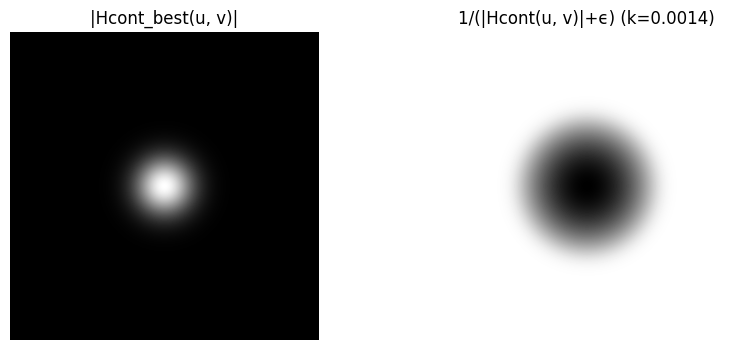

In [37]:
from scipy.optimize import minimize_scalar
sigma = 2.5
kernel_size = 1036
kernel = gaussian_kernel(kernel_size, sigma)
H = fft2(kernel, s=kernel.shape)
H_mag = np.abs(fftshift(H))
M, N = kernel.shape
u = np.arange(M)
v = np.arange(N)
U, V = np.meshgrid(u - (M - 1) / 2, v - (N - 1) / 2)
H_mag_norm = H_mag / np.max(H_mag)

def loss_fn(k):
    Hcont = np.exp(-k * (U**2 + V**2) / (2 * sigma ** 2))
    return np.mean((Hcont - magnitude_spectrum_1036)**2)

res = minimize_scalar(loss_fn, bounds=(1e-6, 1e-1), method='bounded')
k_opt = res.x

print("Part 2.c.ii")
print("Optimal k =", k_opt)
print("Minimum Error =", loss_fn(k_opt))

Hcont_best = np.exp(-k_opt * (U**2 + V**2) / (2 * sigma ** 2))
Hcont_best = np.abs(Hcont_best)
Hcont_best_inv = np.log10(1/(Hcont_best + 1e-3))



print("\n\nPart 2.c.iii")
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(Hcont_best, cmap='gray')
plt.title('|Hcont_best(u, v)|')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(Hcont_best_inv, cmap='gray')
plt.title(f'1/(|Hcont(u, v)|+ϵ) (k={k_opt:.4f})')
plt.axis('off')
path = os.path.join(outdir, "part_c.png")
plt.savefig(path, dpi=150, bbox_inches='tight')
plt.show()



In [38]:
def padd(img):
    return np.pad(img,((6,6),(6,6),(0,0)), mode='constant', constant_values=0.0)

Part 2.d


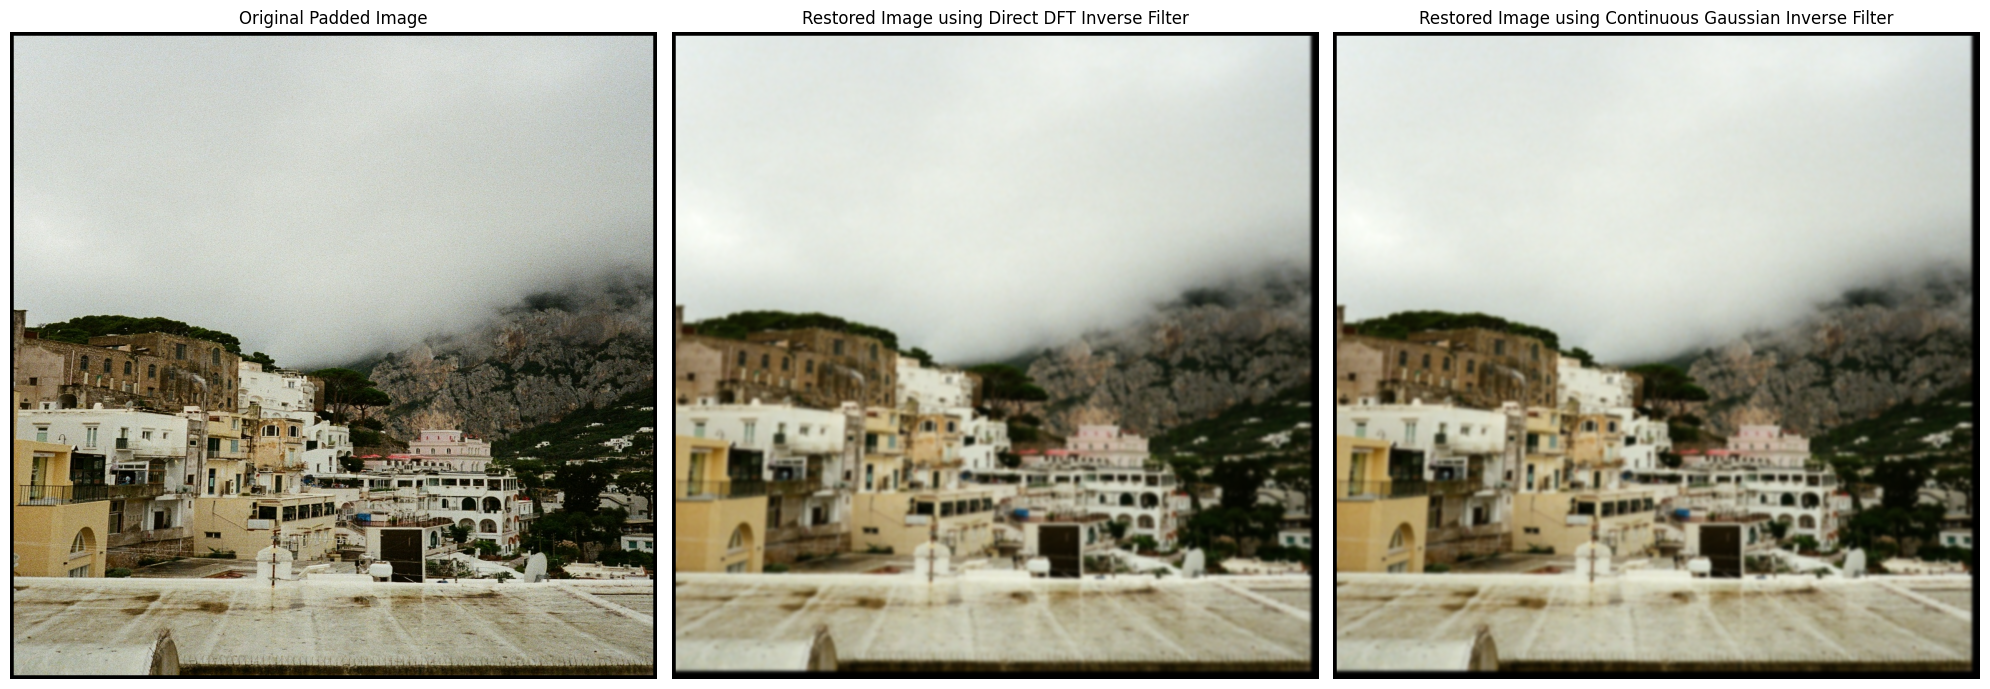

MSE between original image and direct kernel inverse response 0.022681512574166566
MSE between original image and Gaussian fit inverse response 0.022681505150961557


In [ ]:
image_path='./inputs/buildings.jpg'
kernel = gaussian_kernel(1036, 2.5)
img = load_image(image_path)
img_ = img.astype(np.float64) / 255.0
img = padd(img_)
building_padded = padd(blurred)

inv_dft_G_channels = []
for c in range(building_padded.shape[2]):
	fft_channel =  fft2(building_padded[:, :, c])
	filtered_channel =  ifft2(fft_channel * inverse_magnitude_spectrum_1036)
	filtered_channel = np.abs(filtered_channel)
	inv_dft_G_channels.append(filtered_channel)

inv_dft_G = np.stack(inv_dft_G_channels, axis=2)
inv_dft_G = (inv_dft_G - np.min(inv_dft_G)) / (np.max(inv_dft_G) - np.min(inv_dft_G))
# inv_dft_G = (inv_dft_G * 255).astype(np.uint8)

# Process each channel separately for continuous Gaussian inverse filter
inv_dft_G_cont_channels = []
for c in range(building_padded.shape[2]):
	fft_channel =  fft2(building_padded[:, :, c])
	filtered_channel = ifft2(fft_channel * Hcont_best_inv)
	filtered_channel = np.abs(filtered_channel)
	inv_dft_G_cont_channels.append(filtered_channel)

inv_dft_G_cont = np.stack(inv_dft_G_cont_channels, axis=2)
inv_dft_G_cont = (inv_dft_G_cont - np.min(inv_dft_G_cont)) / (np.max(inv_dft_G_cont) - np.min(inv_dft_G_cont))
# inv_dft_G_cont = (inv_dft_G_cont * 255).astype(np.uint8)

print("Part 2.d")

plt.figure(figsize=(20,14))
plt.subplot(1,3,1)
plt.imshow(img)
plt.title("Original Padded Image", fontsize=12)
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(inv_dft_G)
plt.title('Restored Image using Direct DFT Inverse Filter', fontsize=12)
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(inv_dft_G_cont)
plt.title('Restored Image using Continuous Gaussian Inverse Filter', fontsize=12)
plt.axis('off')
path = os.path.join(outdir, "part_d.png")
plt.savefig(path, dpi=150, bbox_inches='tight')
plt.tight_layout()
plt.show()

print("MSE between original image and direct kernel inverse response", compute_mse(img_, blurred))
print("MSE between original image and direct kernel inverse response", compute_mse(img, inv_dft_G))
print("MSE between original image and Gaussian fit inverse response", compute_mse(img, inv_dft_G_cont))
